# The Convex Hull

In [1]:
using Plots
default(legend=false, aspect_ratio=:equal)  # Set convenient defaults for all subsequent plots

## Representing Points in Code

In computational geometry, a fundamental building block is the **point**. For the 2D problems we'll be exploring, a point is simply defined by its $(x,y)$ coordinates. In Julia, we can represent these coordinates as two `Float64` numbers.

To store a *collection of points*, we have a few options. A common and efficient approach is to use a 2D array (a matrix) where each **column represents a single point**. For $n$ points, this would be a `2 x n` matrix. This structure is memory-efficient and makes certain operations very fast:

- **Accessing a single point** (e.g., the i-th point): `p[:, i]`
- **Accessing all x- or y-coordinates**: `p[1, :]` (all x-values) or `p[2, :]` (all y-values)

The main trade-off is that adding a new point is less efficient, as it requires reallocating the array:
```julia
p = [p new_point]  # This creates a new array
```
While packages like `DynamicArrays.jl` can optimize this, our current method is perfectly suitable for learning these algorithms.

In [2]:
# Generate a 2x10 matrix, representing 10 random points in a 2D plane.
p = randn(2, 10)

2×10 Matrix{Float64}:
  0.989617  -0.200196   0.98262  -0.904251  …   0.418002  0.800394  -1.06359
 -0.67067   -1.40891   -1.30156   1.46415      -0.491979  0.523615  -0.112504

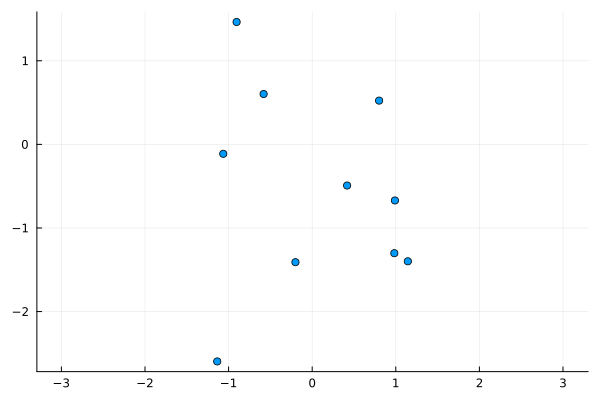

In [3]:
# Create a scatter plot of the points.
# We use array slicing to pass all x-coordinates (the first row) 
# and all y-coordinates (the second row) to the scatter function.
scatter(p[1,:], p[2,:])

## The Convex Hull Problem

The **convex hull** of a set of points $X$ is the smallest convex set that contains all points in $X$. Intuitively, imagine stretching a giant rubber band around all the points; the shape it forms is the convex hull.

Many algorithms exist to compute the convex hull. We will implement the **Jarvis march**, also known as the **gift wrapping algorithm**. 

The algorithm proceeds as follows:

1. Start with the **leftmost point** $p_0$ (the one with the minimum $x$-coordinate), which is guaranteed to be on the hull.
2. Find the next point $p_1$ such that all other points lie to the *right* of the directed line from $p_0$ to $p_1$. This is like wrapping a rope tightly around the points.
3. Repeat this process, finding the next point in the sequence, until we arrive back at our starting point $p_0$.

![Jarvis_march_convex_hull](jarvis_march_convex_hull.png "Convex Hull")

(Image from <https://en.wikipedia.org/wiki/Gift_wrapping_algorithm>)

### Determining Point Orientation

The core operation in the Jarvis march is determining if a point $p_3$ is to the "left" or "right" of a directed line segment from $p_1$ to $p_2$. We can solve this using a clever trick from linear algebra: the **cross product**.

Consider two vectors: $\vec{a} = p_2 - p_1$ and $\vec{b} = p_3 - p_1$. The z-component of their cross product, $\vec{a} \times \vec{b}$, tells us about their orientation:

$$ z = (x_2 - x_1)(y_3 - y_1) - (x_3 - x_1)(y_2 - y_1) $$

- If $z > 0$, the turn from $\vec{a}$ to $\vec{b}$ is **clockwise** (i.e., $p_3$ is to the right of the line $p_1 \to p_2$).
- If $z < 0$, the turn is **counter-clockwise** (i.e., $p_3$ is to the left).
- If $z = 0$, the points $p_1, p_2, p_3$ are **collinear** (all on the same line). For simplicity, our implementation won't handle this special case.

In [4]:
function clockwise_oriented(p1, p2, p3)
    # Calculates the z-component of the cross product of the vectors (p2-p1) and (p3-p1).
    # Returns true if the orientation from vector p1->p2 to p1->p3 is clockwise.
    cross_product_z = (p2[1] - p1[1]) * (p3[2] - p1[2]) - (p2[2] - p1[2]) * (p3[1] - p1[1])
    
    # A positive result indicates a clockwise turn.
    return cross_product_z > 0
end

clockwise_oriented (generic function with 1 method)

In [5]:
# Test Cases
# Test 1: p3 = [2,3] is counter-clockwise ("left") of the vector from [0,0] to [1,1]. Should be false.
println(clockwise_oriented([0,0], [1,1], [2,3]))

# Test 2: p3 = [3,2] is clockwise ("right") of the vector from [0,0] to [1,1]. Should be true.
println(clockwise_oriented([0,0], [1,1], [3,2]))

true
false


With our orientation helper function, we can implement the full algorithm. Notice the nested loop structure:

1. An **outer `while` loop** adds one point to the hull at a time ($p_0, p_1, \ldots$). We use a `while` loop because we don't know in advance how many points will be on the hull.

2. An **inner `for` loop** iterates through all points in the set to find the *next* point on the hull. It finds the point that makes the most extreme clockwise turn relative to the current point.

This structure gives the algorithm a computational complexity of $\mathcal{O}(nh)$, where $n$ is the total number of points and $h$ is the number of points on the convex hull.

In [6]:
function convex_hull(p)
    # Implements the Jarvis march (gift wrapping) algorithm to find the convex hull.

    # Step 1: Start with the leftmost point, which is guaranteed to be on the hull.
    # findmin returns the minimum value and its index; we only need the index.
    _, pointOnHull = findmin(p[1,:]) 
    
    # `hull` will store the indices of the points on the convex hull.
    hull = [pointOnHull]
    
    # Step 2 & 3: Repeatedly find the next point until we get back to the start.
    while length(hull) <= 1 || hull[1] != hull[end]
        # Pick an initial candidate for the next point. Any point other than the current one will do.
        # This modulo arithmetic is a simple way to wrap around and pick the 'next' point in the list.
        nextPoint = hull[end] % size(p, 2) + 1
        
        # Iterate through all points to find the one that makes the most clockwise turn.
        for j in 1:size(p, 2) 
            # If point `j` is more clockwise than our current `nextPoint` candidate...
            if clockwise_oriented(p[:, hull[end]], p[:, nextPoint], p[:, j])
                # ...then we've found a better candidate.
                nextPoint = j
            end
        end
        # Add the best point found to our hull list.
        push!(hull, nextPoint)
    end
    
    return hull
end

convex_hull (generic function with 1 method)

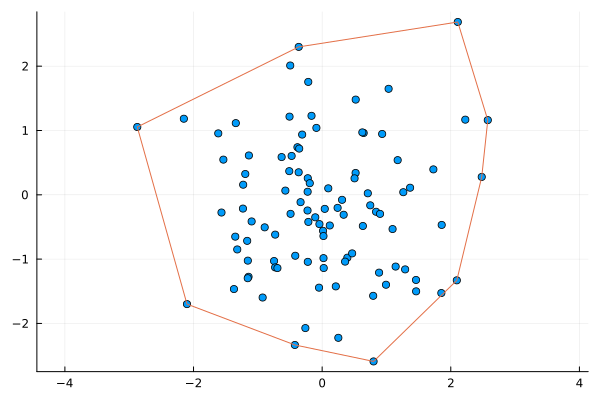

In [7]:
# Example: Compute and draw the convex hull for 100 random points.
p = randn(2, 100)           # 1. Generate a new set of points.
hull = convex_hull(p)       # 2. Compute the hull, which returns a vector of indices.

scatter(p[1,:], p[2,:])     # 3. Plot all points as dots.
plot!(p[1,hull], p[2,hull]) # 4. Overlay the hull polygon by plotting the points at the hull indices.